In [1]:
%matplotlib nbagg

In [2]:
import sys
import os
sys.path.insert(1, os.path.abspath("../build/lib.linux-x86_64-3.9/"))
import pyopencl, numpy
from pyopencl import array
import fabio
import pyFAI
from pyFAI.test.utilstest import UtilsTest
#os.environ["PYOPENCL_CTX"] = "0:1"
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1"
from pyFAI.gui import jupyter
from matplotlib.pyplot import subplots
pyFAI

<module 'pyFAI' from '/home/jerome/workspace-ssd/pyFAI/build/lib.linux-x86_64-3.9/pyFAI/__init__.py'>

In [3]:
img = fabio.open(UtilsTest.getimage("Pilatus6M.cbf")).data
ai = pyFAI.load(UtilsTest.getimage("Pilatus6M.poni"))
npt = 1000
method = ["no", "csr", None]
unit="r_mm"
ai

Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m
SampleDetDist= 3.000000e-01m	PONI= 2.254060e-01, 2.285880e-01m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 300.000mm	Center: x=1329.000, y=1310.500 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

<IPython.core.display.Javascript object>


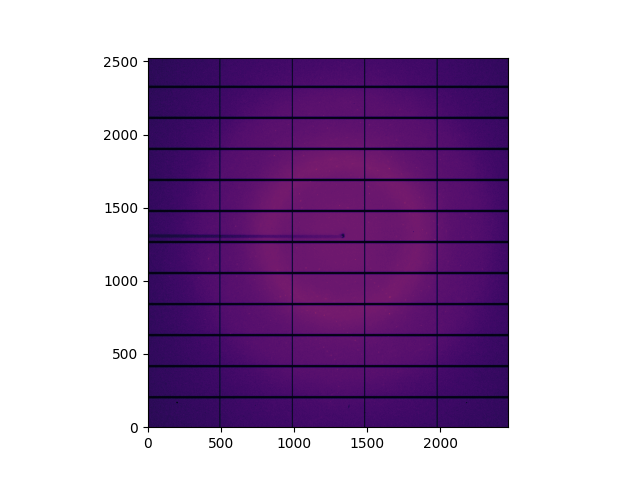

In [4]:
_=jupyter.display(img)

<IPython.core.display.Javascript object>


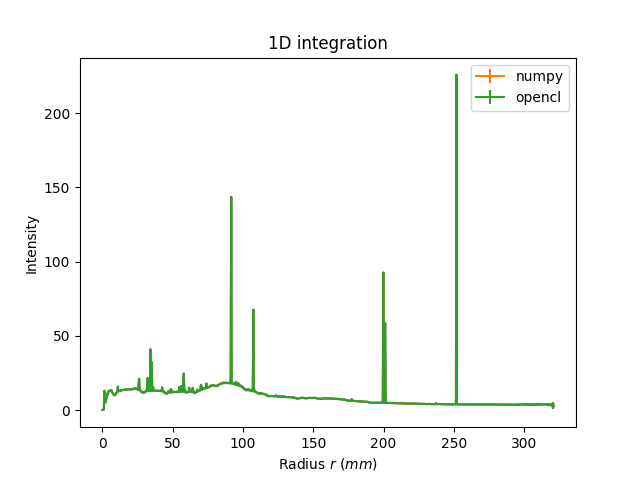

In [5]:
method[-1] = "cython"
res_c = ai.integrate1d(img, npt, unit=unit, method=method, error_model="poisson")
method[-1] = "python"
res_n = ai.integrate1d(img, npt, unit=unit, method=method, error_model="poisson")
method[-1] = "opencl"
res_o = ai.integrate1d(img, npt, unit=unit, method=method, error_model="poisson")
ax = jupyter.plot1d(res_c)
ax.errorbar(*res_n, label="numpy")
ax.errorbar(*res_o, label="opencl")
_=ax.legend()


False True
1481
1851
1917
1927
1928
1928
1928
1928
1928
1928
CPU times: user 3.83 s, sys: 829 ms, total: 4.66 s
Wall time: 3.91 s
CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 195 ms


<IPython.core.display.Javascript object>


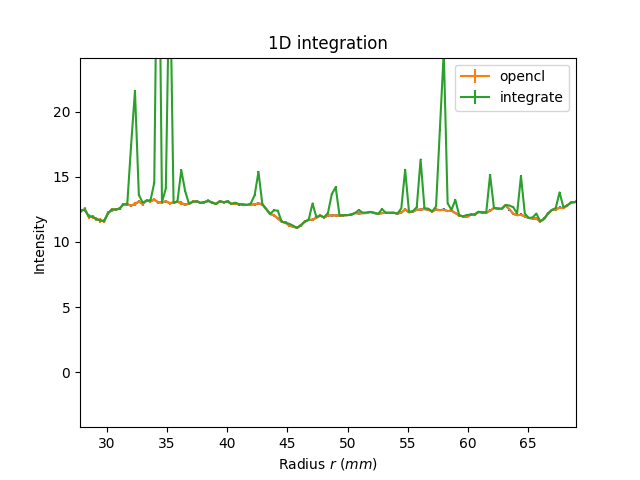

In [12]:
cutof = 0
method[-1] = "python"
res_i = ai.integrate1d(img, npt, unit=unit, method=method, error_model="poisson")
# method[-1] = "python"
%time res_s = ai.sigma_clip_ng(img, npt, unit=unit, method=method, error_model="azimuthal", \
                               max_iter=10, thres=cutof)
method[-1] = "opencl"
%time res_o = ai.sigma_clip_ng(img, npt, unit=unit, method=method, error_model="azimuthal", \
                               max_iter=10, thres=cutof)

ax = jupyter.plot1d(res_s)
# ax.errorbar(*res_n, label="numpy")
# ax.errorbar(*res_s, label="sigma_clip")
ax.errorbar(*res_o, label="opencl")
ax.errorbar(*res_i, label="integrate")
_=ax.legend()


In [7]:
res_i[0].max()

320.748140374066

In [8]:
def intertp_filter(ary):
    "Interpolate missing values in a 1D array"
    x = numpy.arange(ary.shape[0])
    mask_valid = numpy.isfinite(ary)
    mask_invalid = numpy.logical_not(mask_valid)
    where = numpy.where(mask_valid)[0]
    first = ary[where[0]]
    last = ary[where[-1]]
    ary[mask_invalid] = numpy.interp(x[mask_invalid], x[mask_valid], ary[mask_valid],
                                     left=first, right=last)
    return ary

<IPython.core.display.Javascript object>


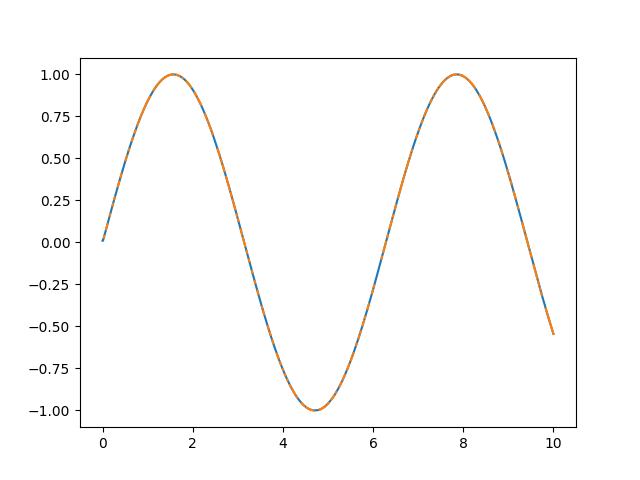

In [9]:
x = numpy.linspace(0,10,1000)
y = numpy.sin(x)
w = numpy.random.randint(0, x.shape[0], size=500)
y[w] = numpy.NaN
z = y.copy()
fig,ax = subplots()
ax.plot(x,intertp_filter(y))
ax.plot(x,z)